## Import Packages

In [2]:
from matplotlib import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
import xgboost as xgb
from Helper_Functions import degree_search
from Helper_Functions import polynomial_search
from joblib import dump, load
import json

pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Read Training Data

In [3]:
training = pd.read_csv("Data/train.csv")

## Basic Data Exploration

In [4]:
training.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
training.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [1]:
training.describe()

NameError: name 'training' is not defined

## Datetime Object Breakdown

In [7]:
training["date"] = training.datetime.apply(lambda x : x.split()[0])
training["hour"] = training.datetime.apply(lambda x : x.split()[1].split(":")[0])
training["weekday"] = training.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
training["month"] = training.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

## Categorical Type Creation

In [8]:
# Mapping to strings
training["season"] = training.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
training["weather"] = training.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

# Mapping to categories

categoryVariables = ["season","weather", "weekday"]
textCategories = ["season","weather", "weekday"]
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]


for var in categoryVariables:
    training[var] = training[var].astype("category")

In [9]:
numericVariables = ['atemp', 'humidity', 'windspeed']

## Missing Value Analysis

<AxesSubplot:>

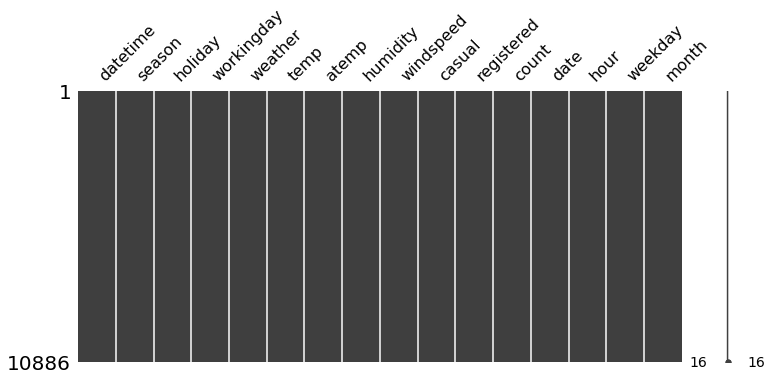

In [10]:
msno.matrix(training,figsize=(12,5))

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

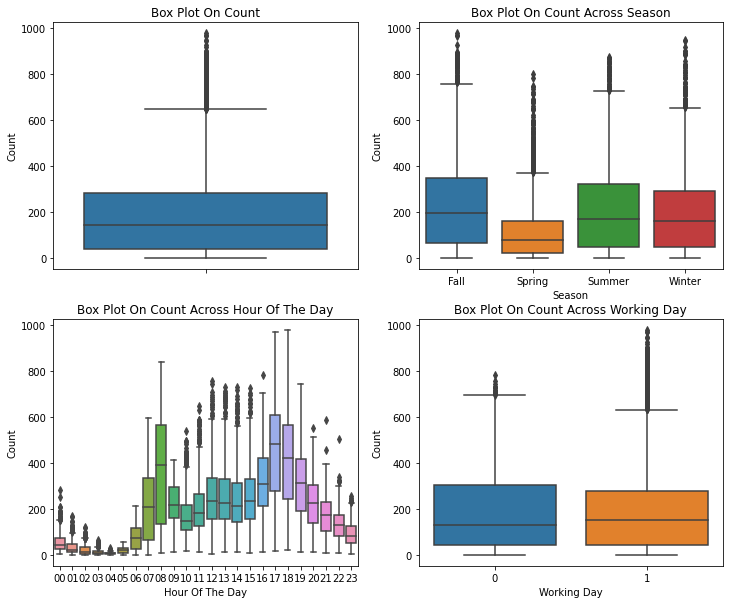

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=training,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=training,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=training,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=training,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

## Outlier Removal

In [12]:
# Remove data greater than 3 std away from mean

numeric_cols = ["temp","atemp","humidity","windspeed","casual","registered","count"]

print("before outlier removal, " + str(training.shape[0]) + " rows")

for col in numeric_cols:
    training = training[np.abs(training[col]-training[col].mean())<=(3*training[col].std())] 
    
print("after outlier removal, " + str(training.shape[0]) + " rows")

before outlier removal, 10886 rows
after outlier removal, 10212 rows


## Get Dummies & Bins

In [13]:
# Unrepeatable
bins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
training[binVariables] = bins.fit_transform(training[binVariables])
training[binVariables] = training[binVariables].astype("category")

In [14]:
pd.get_dummies(training[textCategories+binVariables])

,season_Fall,season_Spring,season_Summer,season_Winter,weather_ Clear + Few clouds + Partly cloudy + Partly cloudy,"weather_ Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog","weather_ Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","weather_ Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",weekday_Friday,weekday_Monday,...,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,hour_0.0,hour_1.0,hour_2.0,hour_3.0,hour_4.0,hour_5.0,hour_6.0
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
10882,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10883,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
10884,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [15]:
dummie_cols = pd.get_dummies(training[textCategories+binVariables]).columns
training = training.join(pd.get_dummies(training[textCategories+binVariables]))

## Numeric Feature Scaling - especially for SVM

In [16]:
# scaler = StandardScaler()
# training['humidity'] = scaler.fit_transform(training[['humidity']])
# training['atemp'] = scaler.fit_transform(training[['atemp']])

## Correlation Map

<AxesSubplot:>

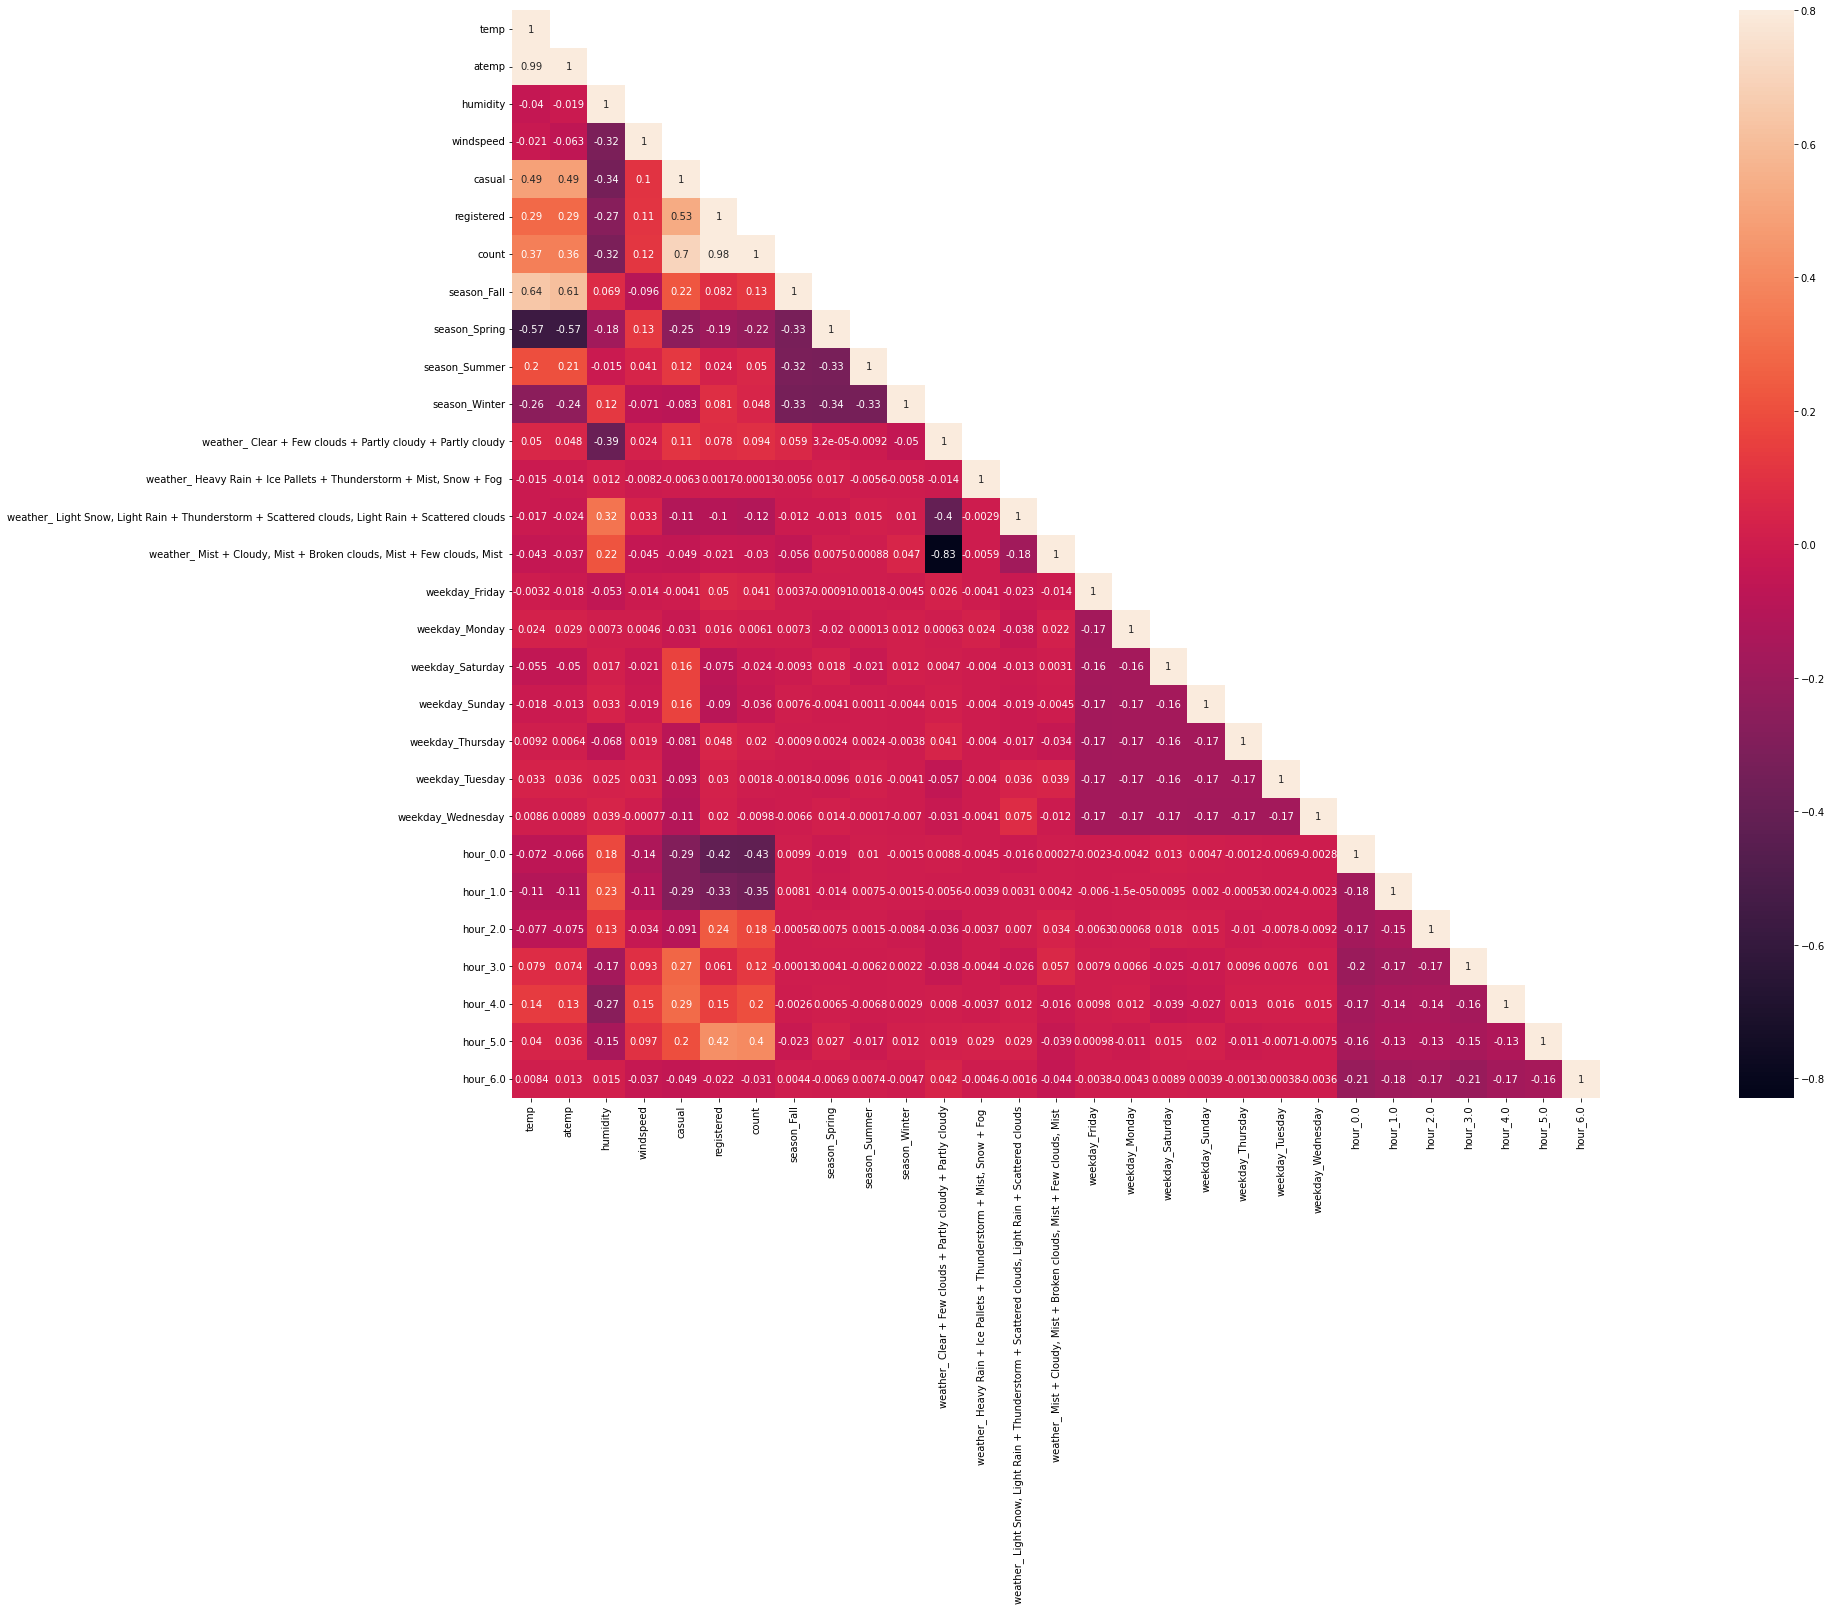

In [17]:
corrMatt = training[numeric_cols+list(dummie_cols)].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(50,20)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

## Degree Search

In [18]:
df, degree_dict = degree_search(df=training[['atemp', 'temp', 'windspeed', 'humidity','count']], dep='count')

[0.13191871136884126]
[0.13191871136884126, 0.13114760009968474]
[0.13191871136884126, 0.13114760009968474, 0.12513179195900004]
[0.13191871136884126, 0.13114760009968474, 0.12513179195900004, 0.11640379097429987]
[0.13191871136884126, 0.13114760009968474, 0.12513179195900004, 0.11640379097429987, 0.10619828213241034]
[0.13468572648848887]
[0.13468572648848887, 0.13195890215679262]
[0.13468572648848887, 0.13195890215679262, 0.12533807582713608]
[0.13468572648848887, 0.13195890215679262, 0.12533807582713608, 0.11696057992704068]
[0.13468572648848887, 0.13195890215679262, 0.12533807582713608, 0.11696057992704068, 0.10754506294695876]
[0.013686898958100935]
[0.013686898958100935, 0.009003857500073154]
[0.013686898958100935, 0.009003857500073154, 0.005268460470121972]
[0.013686898958100935, 0.009003857500073154, 0.005268460470121972, 0.0030627042896265166]
[0.013686898958100935, 0.009003857500073154, 0.005268460470121972, 0.0030627042896265166, 0.0018286386315767844]
[0.10036333114602092]


## Dependent & Independent Split

In [19]:
X = training[numericVariables+list(dummie_cols)+alreadyCategories]
y = training['count']

## Polynomial Degree Search

In [20]:
poly_dict = polynomial_search(X, y, highest_degree=2)
poly_dict

{1: 0.6011049142603566, 2: 0.7654376532098296}

## Generate Polynomial Features for Numeric Variables

In [21]:
poly = PolynomialFeatures(1)
X = poly.fit_transform(X)

X.shape

(10212, 28)

## Feature Selection - Variance Thresholding

In [22]:
sel = VarianceThreshold(threshold=(.91 * (1 - .91)))
X = sel.fit_transform(X)

## Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=1)

## Linear Regression

In [24]:
lreg = LinearRegression()
lreg.fit(X_train, y_train)

lreg.score(X_test, y_test)

predictions = lreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=lreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.6000616542943236; 
RMSLE: 1.1218114933841408


## Support Vector Regression

In [25]:
svreg = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svreg.fit(X_train, y_train)

svreg.score(X_test, y_test)

predictions = svreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=svreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.47372945595960836; 
RMSLE: 0.920995028926754


## Random Forest Regressor

In [26]:
rfreg = RandomForestRegressor(max_depth=2, random_state=0)
rfreg.fit(X_train, y_train)

rfreg.score(X_test, y_test)

predictions = rfreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=rfreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.40298838131365877; 
RMSLE: 0.9846269896902523


## Hyperparameter Tuning

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Training with random_grid

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)


ar = rf_random.score(X_test, y_test)

predictions = rf_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Adjusted R squared: 0.7654076095351909; 
RMSLE: 0.7295152585067554


## Gradient Boosting Regressor

In [27]:
gbreg = GradientBoostingRegressor(random_state=0)
gbreg.fit(X_train, y_train)

gbreg.score(X_test, y_test)

predictions = gbreg.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=gbreg.score(X_test, y_test), 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Adjusted R squared: 0.70964494721279; 
RMSLE: 0.8593992114720207


In [51]:
# Number of trees in gbm
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# Training with random_grid

gb = GradientBoostingRegressor(random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
gb_random.fit(X_train, y_train)


ar = gb_random.score(X_test, y_test)

predictions = gb_random.predict(X_test)



txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Adjusted R squared: 0.7464923334328224; 
RMSLE: 0.8124874226668816


## Hyperparameter Tuning

## XGBoost

In [49]:
train_data = xgb.DMatrix(X_train, y_train)
test_data = xgb.DMatrix(X_test, y_test)

params = {"booster": 'gbtree',
              "objective" : "reg:squaredlogerror",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": 500,
              "max_depth" : 5,
              "reg_alpha" : 0.01,
              "reg_lambda" : 0.01,
              "gamma": 5,
              "num_threads" : 20,
              "min_child_weight" : 5,
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": 500}



cv_result = xgb.cv(params,
                   train_data,
                   1000,
                   early_stopping_rounds=100,
                   stratified=True,
                   nfold=3)

xgboost = xgb.train(params, train_data, 10000)

predictions = xgboost.predict(test_data)

ar = r2_score(y_test,np.maximum(predictions, 0))




txt1 = "Adjusted R squared: {AR}; \nRMSLE: {rmsle}".format(AR=ar, 
                                                            rmsle=np.sqrt(mean_squared_log_error(y_test, np.maximum(predictions, 0))))
print(txt1)

C:\Users\Edwin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


Adjusted R squared: -0.456659658612641; 
RMSLE: 1.2331838380955185


## Save Model

In [28]:
dump(rf_random, 'Models/randomForestEnsemble.joblib') 

## Generate Kaggle Predictions

In [29]:
test_data = pd.read_csv('Data/test.csv')



test_data["date"] = test_data.datetime.apply(lambda x : x.split()[0])
test_data["hour"] = test_data.datetime.apply(lambda x : x.split()[1].split(":")[0])
test_data["weekday"] = test_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
test_data["month"] = test_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])


# Mapping to strings
test_data["season"] = test_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
test_data["weather"] = test_data.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })





# Mapping to categories

categoryVariables = ["season","weather", "weekday"]
textCategories = ["season","weather", "weekday"]
alreadyCategories = ["holiday", "workingday"]
binVariables = ["hour"]


for var in categoryVariables:
    test_data[var] = test_data[var].astype("category")
    
    
    
# Unrepeatable
bins = KBinsDiscretizer(n_bins=7, encode='ordinal', strategy='uniform')
test_data[binVariables] = bins.fit_transform(test_data[binVariables])
test_data[binVariables] = test_data[binVariables].astype("category")


dummie_cols = pd.get_dummies(test_data[textCategories+binVariables]).columns
test_data = test_data.join(pd.get_dummies(test_data[textCategories+binVariables]))

X = test_data[numericVariables+list(dummie_cols)+alreadyCategories]


X = poly.transform(X)
X = sel.transform(X)

test_data['count'] = rf_random.predict(X)

test_data.to_csv('Data/test_labelled.csv')

In [33]:
test_data[['datetime', 'count']].to_csv('Data/test_submission.csv', index=False)

In [32]:
test_data[['datetime', 'count']]

,datetime,count
0,2011-01-20 00:00:00,11.100054
1,2011-01-20 01:00:00,9.296056
2,2011-01-20 02:00:00,9.296056
3,2011-01-20 03:00:00,10.096431
4,2011-01-20 04:00:00,30.691040
...,...,...
6488,2012-12-31 19:00:00,206.653003
6489,2012-12-31 20:00:00,75.687563
6490,2012-12-31 21:00:00,64.693039
6491,2012-12-31 22:00:00,56.792829
